# Compute phosphorylation volcano plots and replicate-replicate correation  - October 12, 2017
Switch to the Seaborn look and feel used for the other graphics later, this is exploratory analysis.  Updates the 101416 version by adding new correlation plots.  Does not rewrite the existing plots.  Updated from the 062817 version with final text labels, font sizes, legend positions, etc. for the paper.

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

##Configure directories

In [2]:
phospho_file = os.path.join('..','..','phosphorylation-data-sets','McKenna2014','aggregated_replicateABC_tukey_orig.txt')
out_dir = os.path.join('..','..','phosphorylation-data-sets','McKenna2014','visualization')

## Load the EGFR phosphorylation data
Use the version that has p-values for all pairs of time point comparisons from Tukey HSD test.  Columns of the form **tp2-tp1** are the p-value columns, which use indices and not minutes.

In [3]:
phospho_df = pd.read_csv(phospho_file, sep='\t')
print 'Loaded %d peptides' % (len(phospho_df))
print 'Data frame columns:'
print phospho_df.columns.values
phospho_df.head()

Loaded 1068 peptides
Data frame columns:
['peptide' 'protein' 'gene.name' 'minimum.tukey.p.value'
 'median.tukey.p.value' 'rep1.tp0' 'rep1.tp2' 'rep1.tp4' 'rep1.tp8'
 'rep1.tp16' 'rep1.tp32' 'rep1.tp64' 'rep1.tp128' 'rep2.tp0' 'rep2.tp2'
 'rep2.tp4' 'rep2.tp8' 'rep2.tp16' 'rep2.tp32' 'rep2.tp64' 'rep2.tp128'
 'rep3.tp0' 'rep3.tp2' 'rep3.tp4' 'rep3.tp8' 'rep3.tp16' 'rep3.tp32'
 'rep3.tp64' 'rep3.tp128' 'tp2-tp1' 'tp3-tp1' 'tp4-tp1' 'tp5-tp1' 'tp6-tp1'
 'tp7-tp1' 'tp8-tp1' 'tp3-tp2' 'tp4-tp2' 'tp5-tp2' 'tp6-tp2' 'tp7-tp2'
 'tp8-tp2' 'tp4-tp3' 'tp5-tp3' 'tp6-tp3' 'tp7-tp3' 'tp8-tp3' 'tp5-tp4'
 'tp6-tp4' 'tp7-tp4' 'tp8-tp4' 'tp6-tp5' 'tp7-tp5' 'tp8-tp5' 'tp7-tp6'
 'tp8-tp6' 'tp8-tp7' 'median.tp0' 'median.tp2' 'median.tp4' 'median.tp8'
 'median.tp16' 'median.tp32' 'median.tp64' 'median.tp128']


,peptide,protein,gene.name,minimum.tukey.p.value,median.tukey.p.value,rep1.tp0,rep1.tp2,rep1.tp4,rep1.tp8,rep1.tp16,...,tp8-tp6,tp8-tp7,median.tp0,median.tp2,median.tp4,median.tp8,median.tp16,median.tp32,median.tp64,median.tp128
0,-.n[305.21]MRK[432.30]ET[181.01]PPPLVPPAAR.E,"Q9BQA1,B4DJP0,B4DP38",WDR77,0.045053,0.874070,3.266944,2.848139,2.580626,3.058835,2.762461,...,0.965091,0.376328,2.76679,2.68569,2.42117,2.81289,2.12906,2.89894,2.79520,3.11382
1,-.n[305.21]MSTTAGY[243.03]LARR.A,Q96SA0,Putative uncharacterized protein,0.004737,0.730298,5.606161,4.002793,3.587753,3.832577,4.777530,...,0.028093,0.115603,7.69423,3.99119,3.82037,4.34460,4.75965,5.04384,5.77301,8.24482
2,K.n[305.21]AAASGQPRPEMQC[160.03]PAEHEEDMY[243....,Q96BN8,FAM105B,0.005700,0.755195,0.099820,0.861090,0.568702,0.498091,0.364445,...,0.992850,0.999629,0.10590,0.86109,0.56870,0.49809,0.36445,0.23328,0.15722,0.11192
3,K.n[305.21]AAGPAS[167.00]PPEEDPER.T,Q96KM6,ZNF512B,0.725082,0.998435,0.369111,0.760905,0.535401,0.586129,0.503314,...,0.999924,0.999968,0.70996,0.76090,0.74556,0.58613,0.65659,0.56510,0.70899,0.59856
4,K.n[305.21]AALGLQDS[167.00]DDEDAAVDIDEQIESMFNS...,"Q7L014,A8K6X3,D3DQA6",DDX46,0.001268,0.476125,5.980349,5.078731,4.807882,4.988418,4.692977,...,0.030959,0.091643,5.77342,5.13979,4.39768,4.98842,4.58252,4.63332,4.95409,5.95735


## Recompute the medians
Confirm that the medians were computed correctly.  Create nz.median.tp<n> columns, which are the non-zero medians used to visualize fold changes in the heat map.  These use the single non-zero replicate when two of the three are 0.

In [4]:
def nz_median(row, time):
    reps = [row['rep1.tp' + time], row['rep2.tp' + time], row['rep3.tp' + time]]
    med = np.median(reps)
    if med == 0:
        print 'Median is 0 for {}'.format(row['peptide'])
        med = max(reps) # Take the only non-zero value
        assert med != 0, 'All replicates are 0: {}'.format(row['peptide'])
    else:
        assert np.isclose(med, row['median.tp' + time], atol=1e-4), 'Unexpected median: {}\t{}\t{}'.format(row['peptide'], med, row['median.tp' + time])
    return med

times = [0, 2, 4, 8, 16, 32, 64, 128]
for time in times:
    time = str(time)
    phospho_df['nz.median.tp' + time] = phospho_df.apply(lambda row: nz_median(row, time), axis=1)

Median is 0 for R.n[305.21]NSNSYGIPEPAHAYAQPQTTTPLPAVSGS[167.00]PGAAITPLPSTQNGPVFAK[432.30].A
Median is 0 for R.n[305.21]TSQDY[243.03]DQLPSC[160.03]SDGSQAPARPPK[432.30]PRPR.R
Median is 0 for R.n[305.21]VNS[167.00]DC[160.03]DSVLPSNFLLGGNIFDPLNLNSLLDEEVSR.T


## Compute log2 fold change
Use the non-zero medians.  Switch to time point indices to match the p-value column names.

In [5]:
def log2fc(row, time1, time2):
    return np.log2(row['nz.median.tp' + time1]/row['nz.median.tp' + time2])

# With respect to the first time point, 0 min
for tp_index in range(1,len(times)):
    time = str(times[tp_index]) # 0-based indexing for the time list
    tp_index = str(tp_index + 1) # Switch to 1-based indexing for the column headers
    phospho_df['log2fc.tp' + tp_index + '-tp1'] = phospho_df.apply(lambda row: log2fc(row, time, '0'), axis=1)

# With respect to previous time point, skip the 0 min comparison
for tp_index in range(2,len(times)):
    prev_tp_index = tp_index - 1
    prev_time = str(times[prev_tp_index]) # 0-based indexing for the time list
    cur_time = str(times[tp_index])
    tp_index = str(tp_index + 1) # Switch to 1-based indexing for the column headers
    prev_tp_index = str(prev_tp_index + 1)
    phospho_df['log2fc.tp' + tp_index + '-tp' + prev_tp_index] = phospho_df.apply(lambda row: log2fc(row, cur_time, prev_time), axis=1)

# Use log2FoldChange011215.txt as a reference
assert np.isclose(phospho_df.ix[phospho_df['peptide'] == 'K.n[305.21]AK[432.30]PPADPAAAAS[167.00]PC[160.03]R.A','log2fc.tp3-tp1'],
                  -1.030512, atol=1e-4)
assert np.isclose(phospho_df.ix[phospho_df['peptide'] == 'K.n[305.21]DDSHSAEDS[167.00]EDEK[432.30]EDHK[432.30].N','log2fc.tp6-tp1'],
                  -0.681944, atol=1e-4)
assert np.isclose(phospho_df.ix[phospho_df['peptide'] == 'R.n[305.21]NSNSYGIPEPAHAYAQPQTTTPLPAVSGS[167.00]PGAAITPLPSTQNGPVFAK[432.30].A', 'log2fc.tp2-tp1'],
                  0.152612, atol=1e-4)
assert np.isclose(phospho_df.ix[phospho_df['peptide'] == 'R.n[305.21]YDERPGPS[167.00]PLPHR.D','log2fc.tp8-tp1'],
                  -0.435632, atol=1e-4)

# Compute manually
assert np.isclose(phospho_df.ix[phospho_df['peptide'] == 'R.n[305.21]HDS[167.00]PDLAPNVTYSLPR.T','log2fc.tp6-tp5'],
                  -5.98827E-05, atol=1e-4)
assert np.isclose(phospho_df.ix[phospho_df['peptide'] == 'R.n[305.21]QSPEDVY[243.03]FSK[432.30].S','log2fc.tp6-tp5'],
                  0.472414572, atol=1e-4)
assert np.isclose(phospho_df.ix[phospho_df['peptide'] == 'K.n[305.21]TLEPVK[432.30]PPTVPNDY[243.03]MTSPAR.L','log2fc.tp3-tp2'],
                  -0.900428734, atol=1e-4)
assert np.isclose(phospho_df.ix[phospho_df['peptide'] == 'R.n[305.21]VNS[167.00]DC[160.03]DSVLPSNFLLGGNIFDPLNLNSLLDEEVSR.T','log2fc.tp3-tp2'],
                  1.579012178, atol=1e-4)

print phospho_df.columns.values

['peptide' 'protein' 'gene.name' 'minimum.tukey.p.value'
 'median.tukey.p.value' 'rep1.tp0' 'rep1.tp2' 'rep1.tp4' 'rep1.tp8'
 'rep1.tp16' 'rep1.tp32' 'rep1.tp64' 'rep1.tp128' 'rep2.tp0' 'rep2.tp2'
 'rep2.tp4' 'rep2.tp8' 'rep2.tp16' 'rep2.tp32' 'rep2.tp64' 'rep2.tp128'
 'rep3.tp0' 'rep3.tp2' 'rep3.tp4' 'rep3.tp8' 'rep3.tp16' 'rep3.tp32'
 'rep3.tp64' 'rep3.tp128' 'tp2-tp1' 'tp3-tp1' 'tp4-tp1' 'tp5-tp1' 'tp6-tp1'
 'tp7-tp1' 'tp8-tp1' 'tp3-tp2' 'tp4-tp2' 'tp5-tp2' 'tp6-tp2' 'tp7-tp2'
 'tp8-tp2' 'tp4-tp3' 'tp5-tp3' 'tp6-tp3' 'tp7-tp3' 'tp8-tp3' 'tp5-tp4'
 'tp6-tp4' 'tp7-tp4' 'tp8-tp4' 'tp6-tp5' 'tp7-tp5' 'tp8-tp5' 'tp7-tp6'
 'tp8-tp6' 'tp8-tp7' 'median.tp0' 'median.tp2' 'median.tp4' 'median.tp8'
 'median.tp16' 'median.tp32' 'median.tp64' 'median.tp128' 'nz.median.tp0'
 'nz.median.tp2' 'nz.median.tp4' 'nz.median.tp8' 'nz.median.tp16'
 'nz.median.tp32' 'nz.median.tp64' 'nz.median.tp128' 'log2fc.tp2-tp1'
 'log2fc.tp3-tp1' 'log2fc.tp4-tp1' 'log2fc.tp5-tp1' 'log2fc.tp6-tp1'
 'log2fc.tp7-tp1' 'lo

## Generate volcano plots
Also count how many of the significant peptides have fold changes < 2 (on a linear scale).

Phosphorylation change 2 min / 0 min. Significant with < 2-fold change: 46 of 99
Saving volcano-2min-0min-101217
Phosphorylation change 4 min / 0 min. Significant with < 2-fold change: 91 of 131
Saving volcano-4min-0min-101217
Phosphorylation change 8 min / 0 min. Significant with < 2-fold change: 54 of 95
Saving volcano-8min-0min-101217
Phosphorylation change 16 min / 0 min. Significant with < 2-fold change: 47 of 80
Saving volcano-16min-0min-101217
Phosphorylation change 32 min / 0 min. Significant with < 2-fold change: 28 of 54
Saving volcano-32min-0min-101217
Phosphorylation change 64 min / 0 min. Significant with < 2-fold change: 24 of 42
Saving volcano-64min-0min-101217
Phosphorylation change 128 min / 0 min. Significant with < 2-fold change: 32 of 50
Saving volcano-128min-0min-101217
Phosphorylation change 4 min / 2 min. Significant with < 2-fold change: 50 of 58
Saving volcano-4min-2min-101217
Phosphorylation change 8 min / 4 min. Significant with < 2-fold change: 29 of 35
Savi

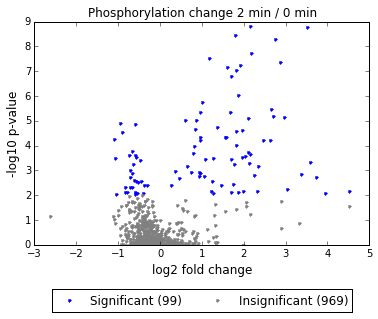

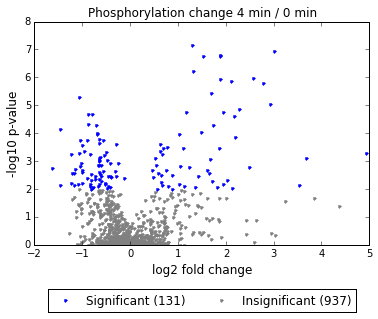

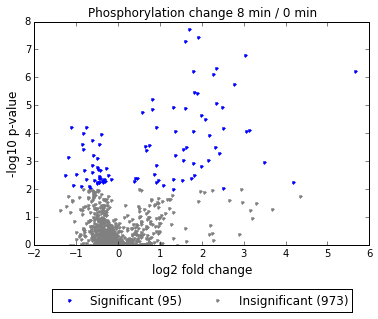

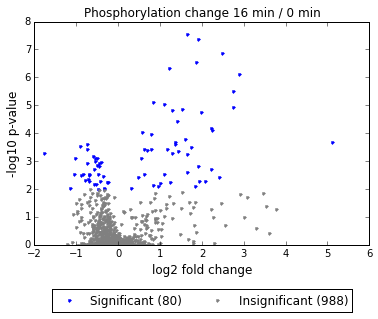

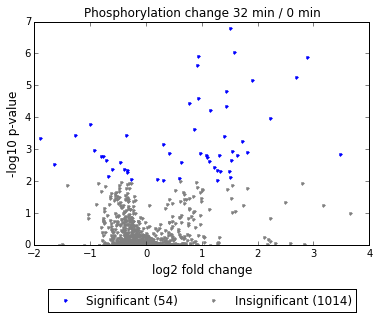

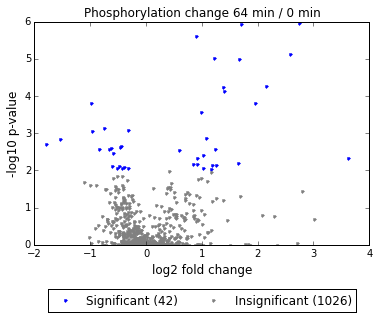

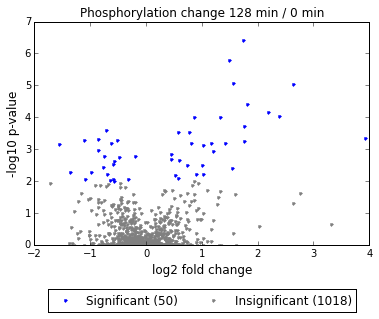

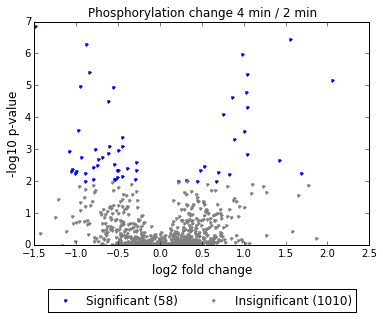

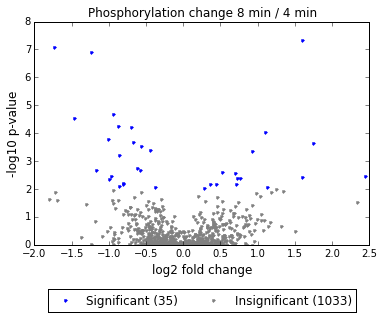

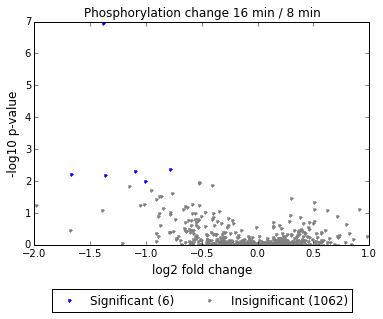

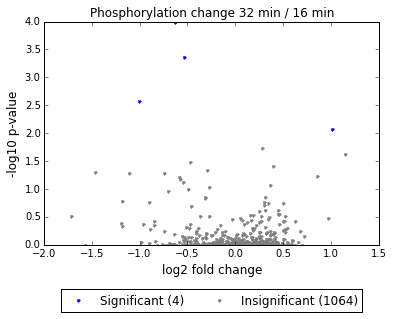

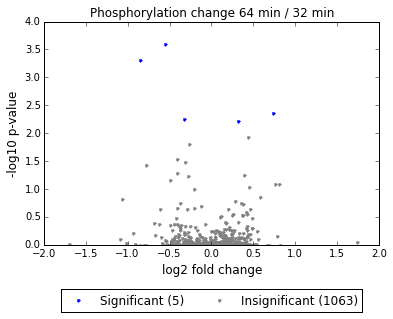

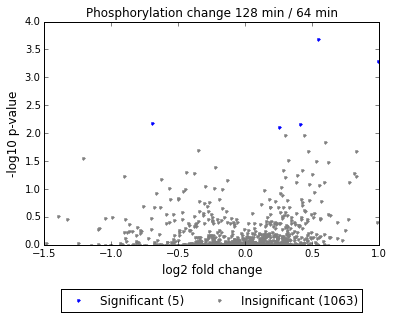

In [46]:
# Take a label of the form 'tp2-tp1', a column in the data frame, and generate a volcano plot
# Optionally save the figure as svg and png
def volcano_plot(label, out_dir = None):
    plt.figure();
    sig_df = phospho_df[phospho_df[label] < 0.01]
    insig_df = phospho_df[phospho_df[label] >= 0.01]
    assert len(sig_df) + len(insig_df) == 1068
    
    sig_label = 'Significant ({})'.format(len(sig_df))
    insig_label = 'Insignificant ({})'.format(len(insig_df))

    plt.plot(sig_df['log2fc.' + label], -np.log10(sig_df[label]), '.', label = sig_label);
    plt.plot(insig_df['log2fc.' + label], -np.log10(insig_df[label]), '.', color='0.5', label = insig_label);
    
    plt.xlabel('log2 fold change', fontsize='large');
    plt.ylabel('-log10 p-value', fontsize='large');
    
    label_parts = label.split('-')
    assert len(label_parts) == 2
    # Remove the 'tp', convert from 1-indexed to 0-indexed
    ind_num = int(label_parts[0][2:]) - 1
    assert ind_num < len(times)
    ind_den = int(label_parts[1][2:]) - 1
    assert ind_den < len(times)
    
    title = 'Phosphorylation change {} min / {} min'.format(times[ind_num], times[ind_den])
    plt.title(title);
    print title + '. Significant with < 2-fold change: {} of {}'.format(len(sig_df[sig_df['log2fc.' + label] < 1]), len(sig_df))
    
    # Only draw a single point of each color in the legend
    # Use two columns to make the labels side-by-side
    legend = plt.legend(numpoints=1, bbox_to_anchor=(0.5, -0.25), borderaxespad=0, loc='center', ncol=2)
    
    # Save the figure
    if not out_dir is None:
        filename = 'volcano-{}min-{}min-101217'.format(times[ind_num], times[ind_den])
        print 'Saving ' + filename
        out_file = os.path.join(out_dir, filename)
        # Include the legend in the saved image http://stackoverflow.com/questions/10101700/moving-matplotlib-legend-outside-of-the-axis-makes-it-cutoff-by-the-figure-box
        plt.savefig(out_file + '.png', dpi=600, bbox_extra_artists=(legend,), bbox_inches='tight')
        plt.savefig(out_file + '.svg', bbox_extra_artists=(legend,), bbox_inches='tight')

# Check some of the expected statistics computed manually
sig_df = phospho_df[phospho_df['tp2-tp1'] < 0.01]
assert len(sig_df) == 99
assert np.isclose(min(sig_df['log2fc.tp2-tp1']), -1.089577707, atol=1e-4)
assert np.isclose(max(sig_df['log2fc.tp2-tp1']), 4.515557659, atol=1e-4)

insig_df = phospho_df[phospho_df['tp7-tp6'] >= 0.01]
assert len(insig_df) == 1063
assert np.isclose(min(insig_df['log2fc.tp7-tp6']), -1.698499654, atol=1e-4)
assert np.isclose(max(insig_df['log2fc.tp7-tp6']), 1.74251519, atol=1e-4)

# With respect to the first time point, 0 min
for tp_index in range(2,len(times)+1):
    label = 'tp{}-tp1'.format(tp_index)
    volcano_plot(label, out_dir)

# With respect to previous time point, skip the 0 min comparison
for tp_index in range(2,len(times)):
    label = 'tp{}-tp{}'.format(tp_index + 1, tp_index)
    volcano_plot(label, out_dir)

## Compute Pearson and Spearman correlation among replicate pairs
Still only consider the peptides that are in all three replicates even though we could include peptides that are identified in two of the three.  Examine Pearson and Spearman correlation coefficients for replicate-replicate pairs.  Also compute the median over the three replicate-replicate pairs.

In [7]:
# rep_a and rep_b are the numeric indices \in {1, 2, 3} in string format
# Compute the correlation over the 8 time points
def compute_corr(row, rep_a, rep_b, corr_type):
    rep_a_data = row.ix['rep' + rep_a + '.tp0':'rep' + rep_a + '.tp128']
    rep_b_data = row.ix['rep' + rep_b + '.tp0':'rep' + rep_b + '.tp128']
    
    # Return only the correlation coefficient, not the p-value
    if corr_type == 'pearson':
        return st.pearsonr(rep_a_data, rep_b_data)[0]
    elif corr_type == 'spearman':
        return st.spearmanr(rep_a_data, rep_b_data)[0]
    else:
        raise RuntimeError('corr_type must be pearson or spearman')

rep_pairs = [(1,2), (1,3), (2,3)]
corr_types = ['pearson', 'spearman']
corr_cols = []
for rep_pair in rep_pairs:
    for corr_type in corr_types:
        rep_a = str(rep_pair[0])
        rep_b = str(rep_pair[1])
        corr_col = corr_type + '.rep' + rep_a + '.rep' + rep_b
        corr_cols.append(corr_col)
        print 'Computing ' + corr_col
        phospho_df[corr_col] = phospho_df.apply(lambda row: compute_corr(row, rep_a, rep_b, corr_type), axis=1)

for corr_type in corr_types:
    corr_col = corr_type + '.median'
    corr_cols.append(corr_col)
    print 'Computing ' + corr_col
    phospho_df[corr_col] = phospho_df.apply(lambda row:\
        np.median([row[corr_type + '.rep1.rep2'], row[corr_type + '.rep1.rep3'], row[corr_type + '.rep2.rep3']]), axis=1)

# Check the correlation coefficients computed manually
assert np.isclose(phospho_df.ix[phospho_df['peptide'] == 'K.n[305.21]AAGPAS[167.00]PPEEDPER.T', 'pearson.rep1.rep2'], -0.628009059, atol=1e-4)
assert np.isclose(phospho_df.ix[phospho_df['peptide'] == 'R.n[305.21]WLDES[167.00]DAEMELR.A', 'pearson.rep1.rep3'], -0.959296073, atol=1e-4)
assert np.isclose(phospho_df.ix[phospho_df['peptide'] == 'R.n[305.21]NLLEDDS[167.00]DEEEDFFLRGPSGPR.F', 'pearson.rep2.rep3'], 0.000138705, atol=1e-4)
assert np.isclose(phospho_df.ix[phospho_df['peptide'] == 'R.n[305.21]AYADSY[243.03]YYEDGGMK[432.30]PR.V', 'pearson.median'], 0.996119319, atol=1e-4)                                                         

Computing pearson.rep1.rep2
Computing spearman.rep1.rep2
Computing pearson.rep1.rep3
Computing spearman.rep1.rep3
Computing pearson.rep2.rep3
Computing spearman.rep2.rep3
Computing pearson.median
Computing spearman.median


## Generate correlation plots
Plot distributions for all peptides and for peptides that are significant at one or more time points.  Also compute the percentage of peptides that meet certain correlation thresholds.  Can't use the `minimum.tukey.p.value` column to get the significant time points because that is over all pairs of time points.  We only consider the comparison to the first or previous time point.

Query: tp2tp1 < 0.01 or tp3tp1 < 0.01 or tp4tp1 < 0.01 or tp5tp1 < 0.01 or tp6tp1 < 0.01 or tp7tp1 < 0.01 or tp8tp1 < 0.01 or tp3tp2 < 0.01 or tp4tp3 < 0.01 or tp5tp4 < 0.01 or tp6tp5 < 0.01 or tp7tp6 < 0.01 or tp8tp7 < 0.01

pearson.rep1.rep2:	19.38% total peptides with correlation >= 0.9
pearson.rep1.rep2:	69.38% total peptides with correlation >= 0.5
pearson.rep1.rep2:	94.01% total peptides with correlation >= 0
pearson.rep1.rep2:	53.23% significant peptides with correlation >= 0.9
pearson.rep1.rep2:	97.72% significant peptides with correlation >= 0.5
pearson.rep1.rep2:	100.00% significant peptides with correlation >= 0
Saving pearson-rep1-rep2-101217

spearman.rep1.rep2:	15.82% total peptides with correlation >= 0.9
spearman.rep1.rep2:	63.39% total peptides with correlation >= 0.5
spearman.rep1.rep2:	92.70% total peptides with correlation >= 0
spearman.rep1.rep2:	39.16% significant peptides with correlation >= 0.9
spearman.rep1.rep2:	91.25% significant peptides with correlation >= 

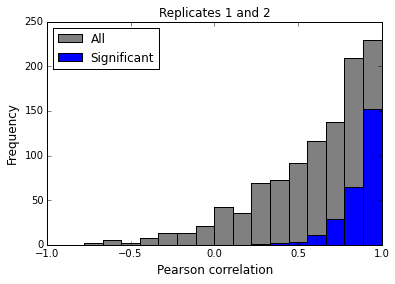

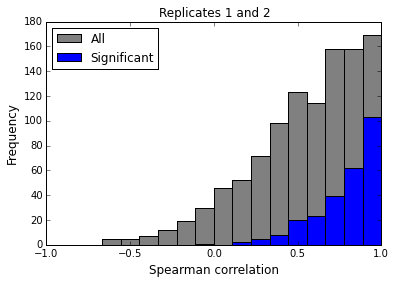

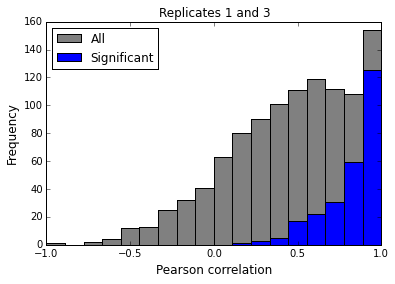

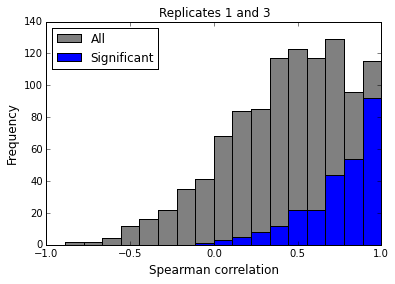

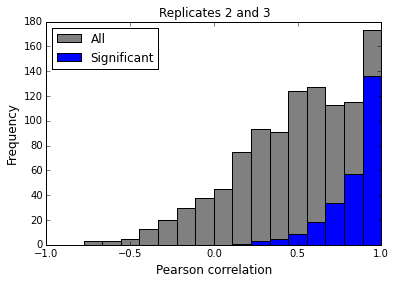

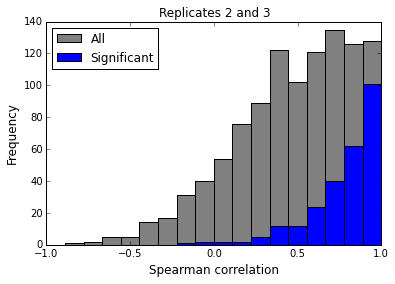

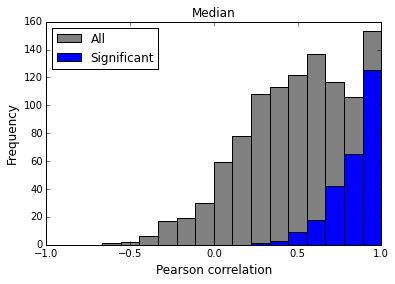

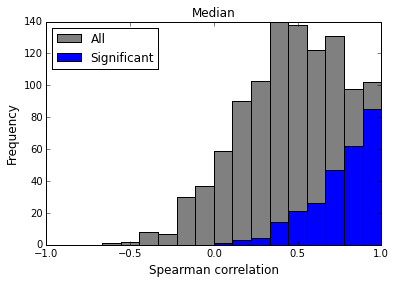

In [26]:
# Only want peptides that are significant for certain pairs of time points
# Build a pandas query
query = []
# With respect to the first time point, 0 min
for tp_index in range(2,len(times)+1):
    label = 'tp{}tp1 < 0.01'.format(tp_index)
    query.append(label)

# With respect to previous time point, skip the 0 min comparison
for tp_index in range(2,len(times)):
    label = 'tp{}tp{} < 0.01'.format(tp_index + 1, tp_index)
    query.append(label)

query = ' or '.join(query)
print 'Query: ' + query + '\n'

# Need to make a copy with renamed columns
# The query syntax tries to perform subtraction between non-existing columns tp2 and tp1 if the column name tp2-tp1 is given
phospho_copy_df = phospho_df.rename(columns = lambda col: col.replace('-', ''))

# Confirm the number of significant peptides is as expected
sig_df = phospho_copy_df.query(query)
assert len(sig_df) == 263, 'Expected 263 significant peptides'

num_peptides = float(len(phospho_df))
num_sig = float(len(sig_df))

# Explicitly set the bins so that the two histograms use identical bins
bins = np.linspace(-1, 1, 19)

for corr_col in corr_cols:
    # Before plotting histograms, display statistics about correlation
    print '{}:\t{:.2f}% total peptides with correlation >= 0.9'.format(corr_col, 100*sum(phospho_df[corr_col] >= 0.9)/num_peptides)
    print '{}:\t{:.2f}% total peptides with correlation >= 0.5'.format(corr_col, 100*sum(phospho_df[corr_col] >= 0.5)/num_peptides)
    print '{}:\t{:.2f}% total peptides with correlation >= 0'.format(corr_col, 100*sum(phospho_df[corr_col] >= 0)/num_peptides)
    print '{}:\t{:.2f}% significant peptides with correlation >= 0.9'.format(corr_col, 100*sum(sig_df[corr_col] >= 0.9)/num_sig)
    print '{}:\t{:.2f}% significant peptides with correlation >= 0.5'.format(corr_col, 100*sum(sig_df[corr_col] >= 0.5)/num_sig)
    print '{}:\t{:.2f}% significant peptides with correlation >= 0'.format(corr_col, 100*sum(sig_df[corr_col] >= 0)/num_sig)
    
    plt.figure();
    counts, edges, patches = plt.hist(phospho_df[corr_col].values, bins, label = 'All', color='0.5');
    patches[0].set_snap(True)
    # Need values to correct problem described in http://stackoverflow.com/questions/22757906/keyerror-0l-when-running-packaged-code
    counts, edges, patches = plt.hist(sig_df[corr_col].values, bins, label = 'Significant');
    patches[0].set_snap(True)
    # pearson.rep1.rep2 becomes Replicates 1 and 2
    title_parts = corr_col.split('.')
    if title_parts[1] == 'median':
        title = 'Median'
    else:
        title = title_parts[1].replace('rep', 'Replicates ') + title_parts[2].replace('rep', ' and ')
    plt.title(title)
    plt.xlabel('{} correlation'.format(title_parts[0].title()), fontsize='large')
    plt.ylabel('Frequency', fontsize='large')
    plt.legend(loc='upper left')

    filename = '{}-101217'.format(corr_col.replace('.','-'))
    print 'Saving ' + filename + '\n'
    out_file = os.path.join(out_dir, filename)
    plt.savefig(out_file + '.png', dpi=600, bbox_inches='tight')
    plt.savefig(out_file + '.svg', bbox_inches='tight')

## Generate additional correlation plots
Drop low intensity peptides.  Plot intensity versus correlation.  There doesn't seem to be a strong relationship between median intensity and correlation.  Do not save these to disk.

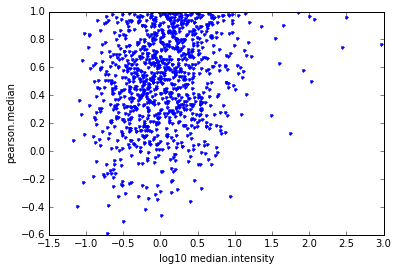

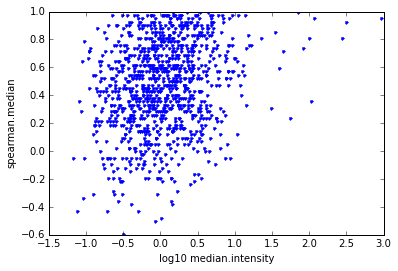

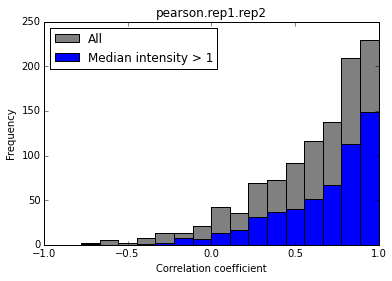

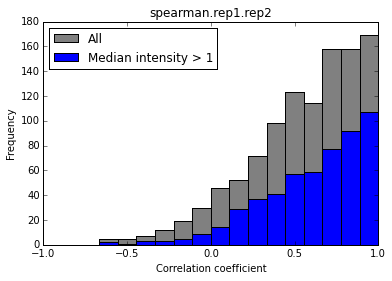

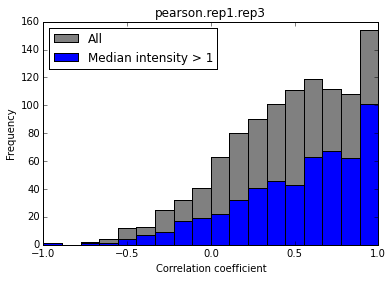

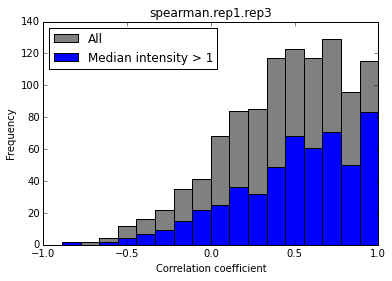

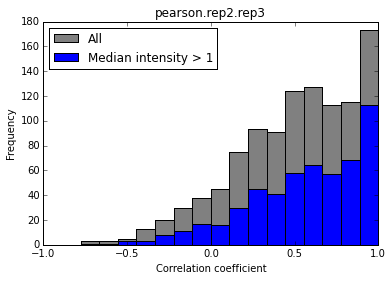

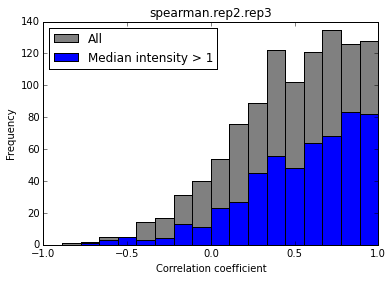

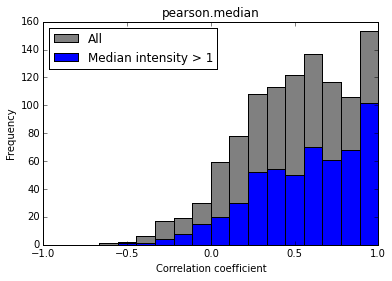

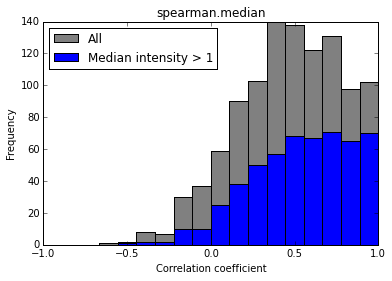

In [9]:
# Compute the median intensity over all time points and all replicate (24 points)
phospho_df['median.intensity'] = phospho_df.apply(lambda row: np.median(row.ix['rep1.tp0':'rep3.tp128']), axis=1)

# Check median intensity
assert np.isclose(phospho_df.ix[phospho_df['peptide'] == 'R.n[305.21]TC[160.03]NS[167.00]PQNSTDSVSDIVPDSPFPGALGSDTR.T', 'median.intensity'], 0.067763277, atol=1e-4)
assert np.isclose(phospho_df.ix[phospho_df['peptide'] == 'R.n[305.21]GEPNVSY[243.03]IC[160.03]SR.Y', 'median.intensity'], 912.5526611, atol=1e-4)

plt.figure();
plt.plot(np.log10(phospho_df['median.intensity']), phospho_df['pearson.median'], '.');
plt.xlabel('log10 median.intensity');
plt.ylabel('pearson.median');

plt.figure();
plt.plot(np.log10(phospho_df['median.intensity']), phospho_df['spearman.median'], '.');
plt.ylim(ymax=1)
plt.xlabel('log10 median.intensity');
plt.ylabel('spearman.median');

high_intensity_df = phospho_df[phospho_df['median.intensity'] >= 1]
assert len(high_intensity_df) == 536

for corr_col in corr_cols:
    plt.figure();
    counts, edges, patches = plt.hist(phospho_df[corr_col].values, bins, label = 'All', color='0.5');
    patches[0].set_snap(True)
    # Need values to correct problem described in http://stackoverflow.com/questions/22757906/keyerror-0l-when-running-packaged-code
    counts, edges, patches = plt.hist(high_intensity_df[corr_col].values, bins, label = 'Median intensity > 1');
    patches[0].set_snap(True)
    plt.title(corr_col)
    plt.xlabel('Correlation coefficient')
    plt.ylabel('Frequency')
    plt.legend(loc='upper left')

## Compare Pearson and Spearman
They generally agree so don't need to show both.  Do not save these to disk.

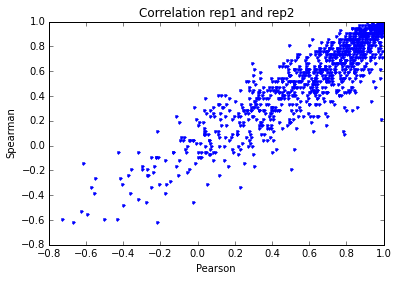

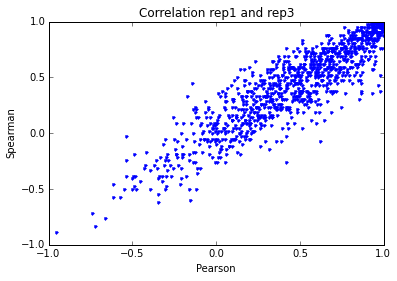

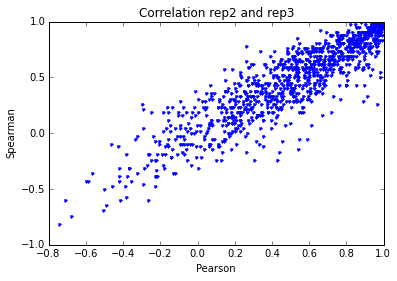

In [10]:
plt.figure()
plt.plot(phospho_df['pearson.rep1.rep2'], phospho_df['spearman.rep1.rep2'], '.');
plt.title('Correlation rep1 and rep2');
plt.xlabel('Pearson');
plt.ylabel('Spearman');

plt.figure()
plt.plot(phospho_df['pearson.rep1.rep3'], phospho_df['spearman.rep1.rep3'], '.');
plt.title('Correlation rep1 and rep3');
plt.xlabel('Pearson');
plt.ylabel('Spearman');

plt.figure()
plt.plot(phospho_df['pearson.rep2.rep3'], phospho_df['spearman.rep2.rep3'], '.');
plt.title('Correlation rep2 and rep3');
plt.xlabel('Pearson');
plt.ylabel('Spearman');

## Compute correlations using all fold changes in a replicate
Consider fold changes with respect to first time point and previous time point.  Need to compute fold changes in each replicate, not with the median.  Store **nan** when the numerator or the denominator is 0.

In [11]:
# Single replicate version
def rep_log2fc(row, rep, time1, time2):
    num = row['rep' + rep + '.tp' + time1]
    denom = row['rep' + rep + '.tp' + time2]
    if num == 0 or denom == 0:
        return np.NAN

    return np.log2(num/denom)

for rep in map(str, range(1,4)):
    # With respect to the first time point, 0 min
    for tp_index in range(1,len(times)):
        time = str(times[tp_index]) # 0-based indexing for the time list
        tp_index = str(tp_index + 1) # Switch to 1-based indexing for the column headers
        phospho_df['rep' + rep + '.log2fc.tp' + tp_index + '-tp1'] = phospho_df.apply(lambda row: rep_log2fc(row, rep, time, '0'), axis=1)

    # With respect to previous time point, skip the 0 min comparison
    for tp_index in range(2,len(times)):
        prev_tp_index = tp_index - 1
        prev_time = str(times[prev_tp_index]) # 0-based indexing for the time list
        cur_time = str(times[tp_index])
        tp_index = str(tp_index + 1) # Switch to 1-based indexing for the column headers
        prev_tp_index = str(prev_tp_index + 1)
        phospho_df['rep' + rep + '.log2fc.tp' + tp_index + '-tp' + prev_tp_index] = phospho_df.apply(lambda row: rep_log2fc(row, rep, cur_time, prev_time), axis=1)

null_log2fc = phospho_df.isnull().sum().sum()

print '{} null log2 fold changes'.format(null_log2fc)
print phospho_df.columns.values
phospho_df.head()

60 null log2 fold changes
['peptide' 'protein' 'gene.name' 'minimum.tukey.p.value'
 'median.tukey.p.value' 'rep1.tp0' 'rep1.tp2' 'rep1.tp4' 'rep1.tp8'
 'rep1.tp16' 'rep1.tp32' 'rep1.tp64' 'rep1.tp128' 'rep2.tp0' 'rep2.tp2'
 'rep2.tp4' 'rep2.tp8' 'rep2.tp16' 'rep2.tp32' 'rep2.tp64' 'rep2.tp128'
 'rep3.tp0' 'rep3.tp2' 'rep3.tp4' 'rep3.tp8' 'rep3.tp16' 'rep3.tp32'
 'rep3.tp64' 'rep3.tp128' 'tp2-tp1' 'tp3-tp1' 'tp4-tp1' 'tp5-tp1' 'tp6-tp1'
 'tp7-tp1' 'tp8-tp1' 'tp3-tp2' 'tp4-tp2' 'tp5-tp2' 'tp6-tp2' 'tp7-tp2'
 'tp8-tp2' 'tp4-tp3' 'tp5-tp3' 'tp6-tp3' 'tp7-tp3' 'tp8-tp3' 'tp5-tp4'
 'tp6-tp4' 'tp7-tp4' 'tp8-tp4' 'tp6-tp5' 'tp7-tp5' 'tp8-tp5' 'tp7-tp6'
 'tp8-tp6' 'tp8-tp7' 'median.tp0' 'median.tp2' 'median.tp4' 'median.tp8'
 'median.tp16' 'median.tp32' 'median.tp64' 'median.tp128' 'nz.median.tp0'
 'nz.median.tp2' 'nz.median.tp4' 'nz.median.tp8' 'nz.median.tp16'
 'nz.median.tp32' 'nz.median.tp64' 'nz.median.tp128' 'log2fc.tp2-tp1'
 'log2fc.tp3-tp1' 'log2fc.tp4-tp1' 'log2fc.tp5-tp1' 'log2fc.tp6-

,peptide,protein,gene.name,minimum.tukey.p.value,median.tukey.p.value,rep1.tp0,rep1.tp2,rep1.tp4,rep1.tp8,rep1.tp16,...,rep3.log2fc.tp5-tp1,rep3.log2fc.tp6-tp1,rep3.log2fc.tp7-tp1,rep3.log2fc.tp8-tp1,rep3.log2fc.tp3-tp2,rep3.log2fc.tp4-tp3,rep3.log2fc.tp5-tp4,rep3.log2fc.tp6-tp5,rep3.log2fc.tp7-tp6,rep3.log2fc.tp8-tp7
0,-.n[305.21]MRK[432.30]ET[181.01]PPPLVPPAAR.E,"Q9BQA1,B4DJP0,B4DP38",WDR77,0.045053,0.874070,3.266944,2.848139,2.580626,3.058835,2.762461,...,-0.490045,0.067316,0.014743,0.170475,-0.086977,-0.000453,-0.297086,0.557360,-0.052573,0.155733
1,-.n[305.21]MSTTAGY[243.03]LARR.A,Q96SA0,Putative uncharacterized protein,0.004737,0.730298,5.606161,4.002793,3.587753,3.832577,4.777530,...,-0.692923,-0.542346,-0.414455,0.861306,0.220742,0.006356,0.091624,0.150577,0.127891,1.275761
2,K.n[305.21]AAASGQPRPEMQC[160.03]PAEHEEDMY[243....,Q96BN8,FAM105B,0.005700,0.755195,0.099820,0.861090,0.568702,0.498091,0.364445,...,0.507383,-0.200021,0.421673,-0.024554,-0.682986,0.186172,-0.418080,-0.707404,0.621694,-0.446227
3,K.n[305.21]AAGPAS[167.00]PPEEDPER.T,Q96KM6,ZNF512B,0.725082,0.998435,0.369111,0.760905,0.535401,0.586129,0.503314,...,-0.422728,-0.323349,-0.152911,-0.166128,-0.057808,0.493731,-0.647667,0.099379,0.170439,-0.013217
4,K.n[305.21]AALGLQDS[167.00]DDEDAAVDIDEQIESMFNS...,"Q7L014,A8K6X3,D3DQA6",DDX46,0.001268,0.476125,5.980349,5.078731,4.807882,4.988418,4.692977,...,-0.391513,-0.199223,-0.096652,0.312721,-0.224969,0.031439,-0.182625,0.192291,0.102570,0.409374


## Generate and save fold change correlation plots

Saving pearson-all-log2fc-rep1-rep2-101217
Saving pearson-all-log2fc-rep1-rep3-101217
Saving pearson-all-log2fc-rep2-rep3-101217
Saving spearman-all-log2fc-rep1-rep2-101217
Saving spearman-all-log2fc-rep1-rep3-101217
Saving spearman-all-log2fc-rep2-rep3-101217


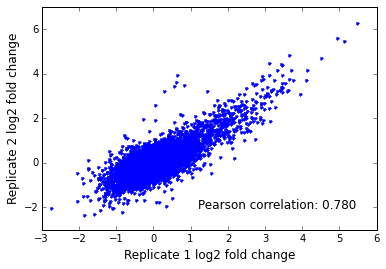

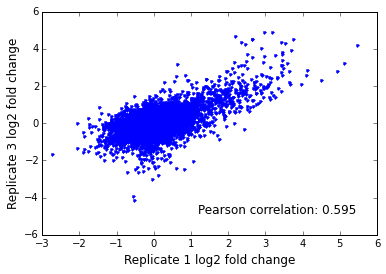

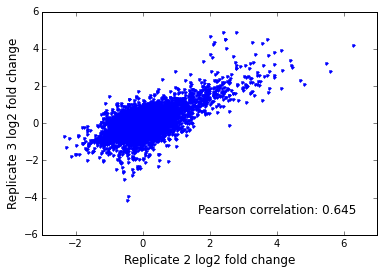

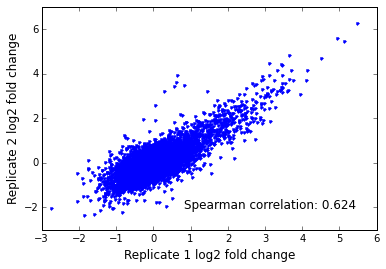

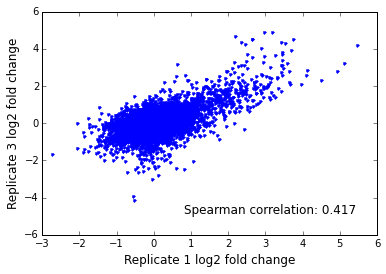

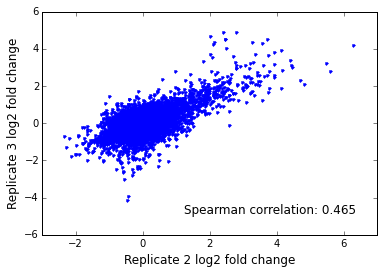

In [16]:
# Compute the correlation using all log2 fold change values for
# all peptides that have complete data
# Takes in two replicate numbers and a data matrix of log2 fold change values
# with dimension: replicates X (peptides with complete data X 13)
def compute_log2fc_corr(all_log2fc, rep_a, rep_b, corr_type, value_type, out_dir = None):
    rep_a_data = all_log2fc[rep_a - 1, :]
    rep_b_data = all_log2fc[rep_b - 1, :]

    # Return only the correlation coefficient, not the p-value
    if corr_type == 'pearson':
        corr = st.pearsonr(rep_a_data, rep_b_data)[0]
    elif corr_type == 'spearman':
        corr = st.spearmanr(rep_a_data, rep_b_data)[0]
    else:
        raise RuntimeError('corr_type must be pearson or spearman')

    # Don't use the legend because we don't want the scatterplot point
    plt.figure()
    plt.plot(rep_a_data, rep_b_data, '.');
    plt.xlabel('Replicate {} {}'.format(rep_a, value_type), fontsize=12);
    plt.ylabel('Replicate {} {}'.format(rep_b, value_type), fontsize=12);
    label = '{} correlation: {:.3f}'.format(corr_type.title(), corr)
    plt.figtext(0.85, 0.2, label, fontsize=12, horizontalalignment='right')

    # Save the figure
    if not out_dir is None:
        if value_type == 'log2 fold change':
            value_type = 'log2fc'
        filename = '{}-all-{}-rep{}-rep{}-101217'.format(corr_type, value_type, rep_a, rep_b)
        print 'Saving ' + filename
        out_file = os.path.join(out_dir, filename)
        plt.savefig(out_file + '.png', dpi=600, bbox_inches='tight')
        plt.savefig(out_file + '.svg', bbox_inches='tight')

    return corr

phospho_complete_df= phospho_df.dropna()

rep1 = phospho_complete_df.loc[:,'rep1.log2fc.tp2-tp1':'rep1.log2fc.tp8-tp7'].values.reshape(-1)
rep2 = phospho_complete_df.loc[:,'rep2.log2fc.tp2-tp1':'rep2.log2fc.tp8-tp7'].values.reshape(-1)
rep3 = phospho_complete_df.loc[:,'rep3.log2fc.tp2-tp1':'rep3.log2fc.tp8-tp7'].values.reshape(-1)
all_log2fc = np.stack((rep1, rep2, rep3))

## Check for the correct size
assert all_log2fc.shape == (3, 1058*13), 'Wrong matrix shape'

## Check a few fold change values
assert np.isclose(all_log2fc[0,0], -0.19792196) # 2 / 0 for first peptide in rep1
assert np.isclose(all_log2fc[0,1], -0.340220534) # 4 / 0 for first peptide in rep1
assert np.isclose(all_log2fc[0,13], -0.486006106) # 2 / 0 for second peptide in rep1
assert np.isclose(all_log2fc[0,1058*13-1], -0.161198669) # 128 / 64 for last peptide in rep1
assert np.isclose(all_log2fc[1,0], 0.185806058) # 2 / 0 for first peptide in rep2

## Check the rep1 rep2 correlation
assert np.isclose(compute_log2fc_corr(all_log2fc, 1, 2, 'pearson', 'log2 fold change'), 0.77966689)
plt.close()

for corr_type in corr_types:
    for rep_pair in rep_pairs:
        compute_log2fc_corr(all_log2fc, rep_pair[0], rep_pair[1], corr_type, 'log2 fold change', out_dir)

## Generate and save intesity correlation plots
The intensities are normalized and are directly comparable.  Use all peptides, no need to filter based on complete data.

Saving pearson-all-intensity-rep1-rep2-101217
Saving pearson-all-intensity-rep1-rep3-101217
Saving pearson-all-intensity-rep2-rep3-101217
Saving spearman-all-intensity-rep1-rep2-101217
Saving spearman-all-intensity-rep1-rep3-101217
Saving spearman-all-intensity-rep2-rep3-101217


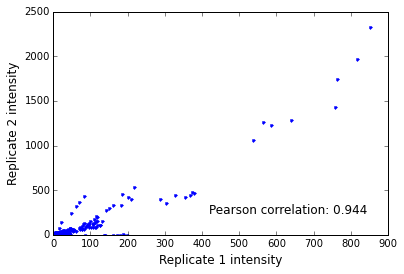

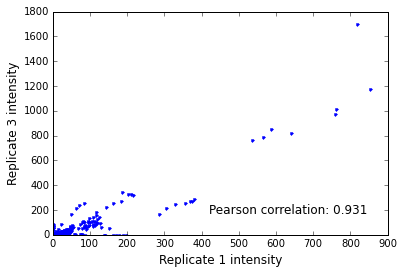

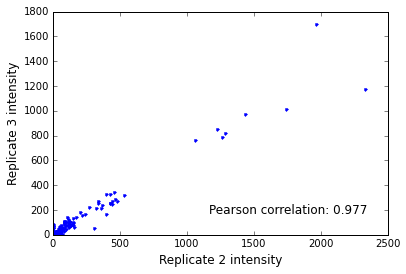

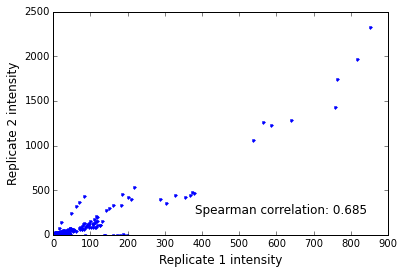

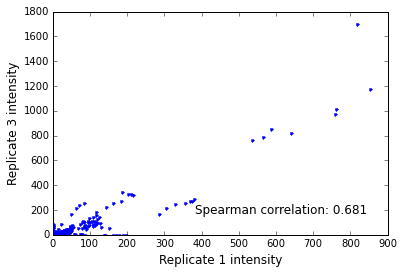

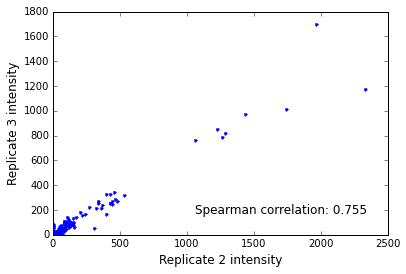

In [17]:
rep1 = phospho_df.loc[:,'rep1.tp0':'rep1.tp128'].values.reshape(-1)
rep2 = phospho_df.loc[:,'rep2.tp0':'rep2.tp128'].values.reshape(-1)
rep3 = phospho_df.loc[:,'rep3.tp0':'rep3.tp128'].values.reshape(-1)
all_intensity = np.stack((rep1, rep2, rep3))

## Check for the correct size
assert all_intensity.shape == (3, 1068*8), 'Wrong matrix shape'

## Check values
assert np.isclose(all_intensity[0,0], 3.266943728) # 0 for first peptide in rep1
assert np.isclose(all_intensity[0,7], 3.427506873) # 128 for first peptide in rep1
assert np.isclose(all_intensity[0,24], 0.369110713) # 0 for fourth peptide in rep1
assert np.isclose(all_intensity[1,33], 5.385093782) # 2 for fifth peptide in rep2

## Check the rep1 rep2 correlation
assert np.isclose(compute_log2fc_corr(all_intensity, 1, 2, 'pearson', 'intensity'), 0.944431245)
plt.close()

for corr_type in corr_types:
    for rep_pair in rep_pairs:
        compute_log2fc_corr(all_intensity, rep_pair[0], rep_pair[1], corr_type, 'intensity', out_dir)

## Generate log scale intensity correlation plots
Don't save these figures

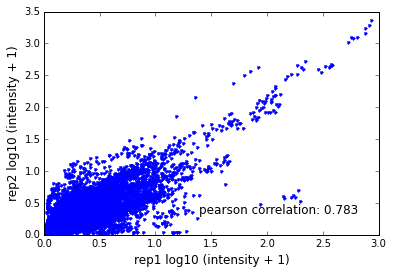

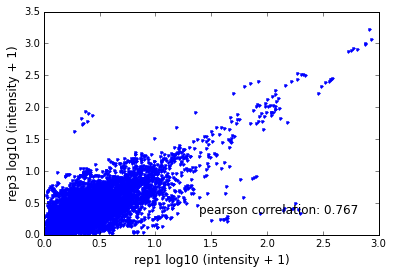

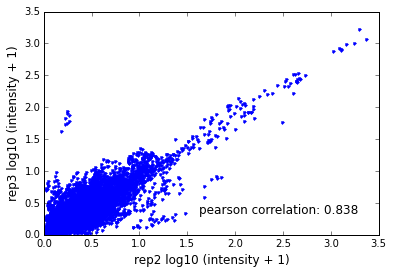

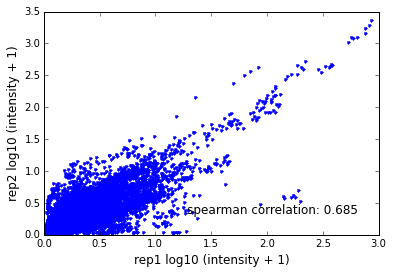

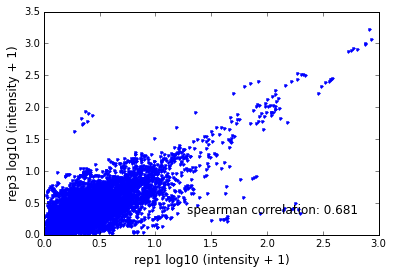

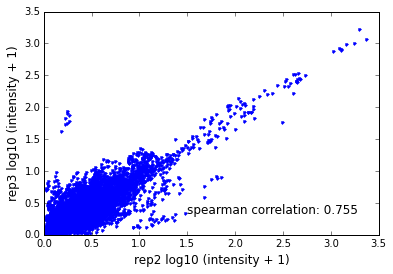

In [14]:
all_log_intensity = np.log10(1 + all_intensity)
for corr_type in corr_types:
    for rep_pair in rep_pairs:
        compute_log2fc_corr(all_log_intensity, rep_pair[0], rep_pair[1], corr_type, 'log10 (intensity + 1)')

## Explore possible histogram problem
The smallest bin, [-1, -0.88888889], has a count of 0 but visually shows a small bar.  http://stackoverflow.com/questions/29791119/extra-bar-in-the-first-bin-of-a-pyplot-histogram shows how to correct this bug.

[   0.    0.    0.    1.    2.    6.   17.   19.   30.   59.   78.  108.
  113.  122.  137.  117.  106.  153.]
[-1.         -0.88888889 -0.77777778 -0.66666667 -0.55555556 -0.44444444
 -0.33333333 -0.22222222 -0.11111111  0.          0.11111111  0.22222222
  0.33333333  0.44444444  0.55555556  0.66666667  0.77777778  0.88888889
  1.        ]


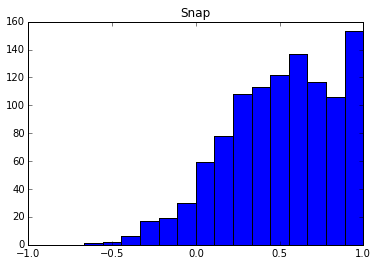

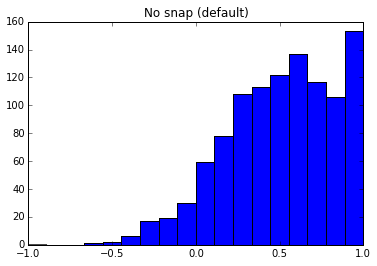

In [15]:
counts, edges, patches = plt.hist(phospho_df['pearson.median'], bins)
plt.title('Snap');
print counts
print edges
patches[0].set_snap(True)

plt.figure();
counts, edges, patches = plt.hist(phospho_df['pearson.median'], bins)
plt.title('No snap (default)');